## Write-up notebook for the Fader Networks section
* Mon 20-Aug
* Aim is to pull out results to go into the Fader Networks section of the write-up.
* Plots for the discriminator network: training curves etc.
* Plots for Fader Network training in the various forms
* t-sne/PCA plots for the speaker embeddings
* plots to go with the gender samples
* speaker recognition sweep?

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# needs to run in the fader-networks branch
# (that's also where all the checkpoints are)
os.chdir('/home/ubuntu/msc-project-fader-networks/')

In [16]:
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from data import NpzFolder, NpzLoader, TBPTTIter
from model import Loop, MaskedMSE
from utils import create_output_dir, wrap, check_grad

from utils import generate_merlin_wav

import notebook_utils as nu

import speaker_recognition as sr

import evaluate_loss_func_for_notebook as el

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

import sklearn.metrics.pairwise as pw

from IPython.display import Audio
import IPython.display

In [4]:
import training_monitor as tm

In [5]:
os.getcwd()

'/home/ubuntu/msc-project-fader-networks'

In [6]:
save_folder = '/home/ubuntu/msc-project-master/msc-project-master/docs/fader/'

## Training Curves

In [446]:
# load in proper baseline... (just the second phase)
tm_base = tm.TrainingMonitor('vctk_all_2_v2_20180716_teachT_noiseT', 
                             exp_name='vctk-all-2-v2', 
                             path="/home/ubuntu/msc-project-master/msc-project-master/training_logs")

tm_base_FF = tm.TrainingMonitor('vctk_all_2_v2_20180716_teachF_noiseF', 
                             exp_name='vctk-all-2-v2', 
                             path="/home/ubuntu/msc-project-master/msc-project-master/training_logs")

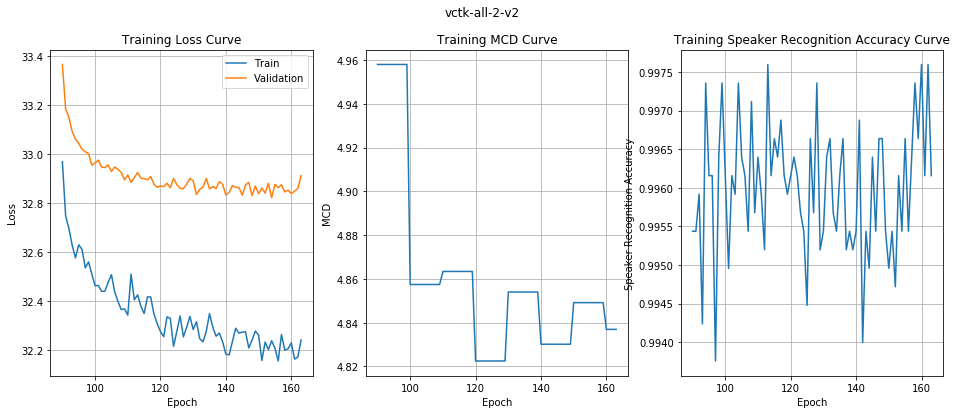

In [11]:
tm_base.plot()

In [21]:
# gender concat trained from baseline
tm_concat_baseline = tm.TrainingMonitor('fader_gender_concat_baseline163_20180720.csv', exp_name='fader_gender_concat_baseline163_20180720', path="/home/ubuntu/msc-project-fader-networks/training_logs")

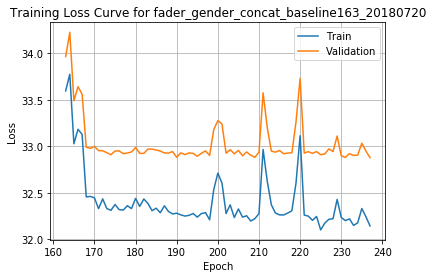

In [22]:
tm_concat_baseline.plot_loss()

In [31]:
print tm_base.data.valid_loss.min()
print tm_concat_baseline.data.valid_reconstruction_loss.min()

32.8213253021
32.8080679389


#### Training curve for write-up

Text(0.5,1,u'Training Curves for Gender Fader Network Starting from Pre-Trained Baseline')

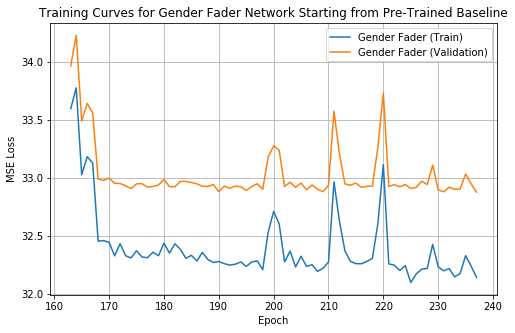

In [44]:
# show just the loss components
plt.figure(figsize=(8,5))
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.train_loss.fillna(method='ffill'))
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.valid_loss.fillna(method='ffill'))
plt.grid(True)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(('Gender Fader (Train)', 'Gender Fader (Validation)'))
plt.title('Training Curves for Gender Fader Network Starting from Pre-Trained Baseline')
#plt.save

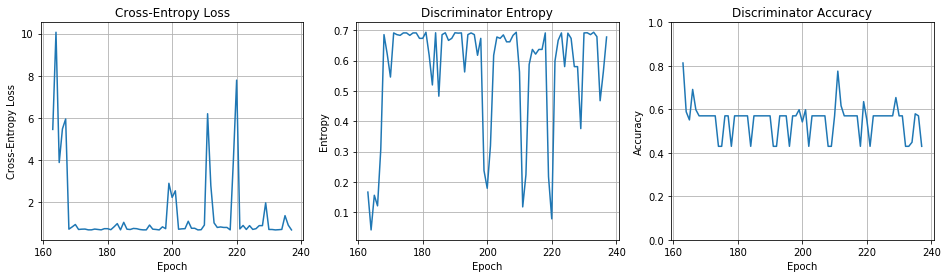

In [62]:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.disc_loss.fillna(method='ffill'))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss')

plt.subplot(1, 3, 2)
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.ent_loss.fillna(method='ffill'))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Discriminator Entropy')

plt.subplot(1, 3, 3)
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.disc_accuracy.fillna(method='ffill'))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Discriminator Accuracy')

plt.savefig(os.path.join(save_folder, 'fader_concat_from_baseline_discriminator_loss_plots'))

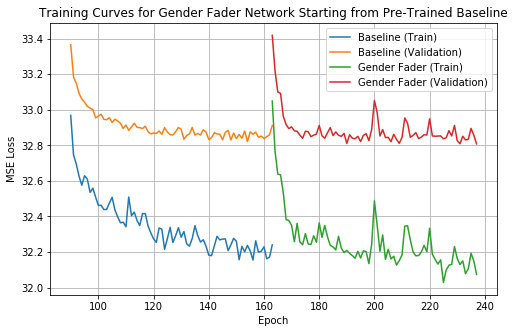

In [72]:
# compare to baseline
plt.figure(figsize=(8,5))
train_mse = tm_concat_baseline.data.train_loss - tm_concat_baseline.data.disc_loss*0.1
plt.plot(tm_base.data.epoch, tm_base.data.train_loss.fillna(method='ffill'))
plt.plot(tm_base.data.epoch, tm_base.data.valid_loss.fillna(method='ffill'))
plt.plot(tm_concat_baseline.data.epoch, train_mse.fillna(method='ffill'))
plt.plot(tm_concat_baseline.data.epoch, tm_concat_baseline.data.valid_reconstruction_loss.fillna(method='ffill'))
plt.grid(True)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(('Baseline (Train)', 'Baseline (Validation)', 'Gender Fader (Train)', 'Gender Fader (Validation)'))
plt.title('Training Curves for Gender Fader Network Starting from Pre-Trained Baseline')
plt.savefig(os.path.join(save_folder, 'fader_concat_from_baseline_training_curves'))

#### Speaker recognition

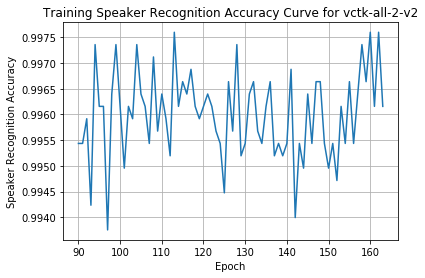

In [65]:
# load in proper baseline... (just the second phase)
tm_base.plot_speaker_recognition()

In [436]:
sr_concat_baseline = tm.TrainingMonitor('fader_concat_baseline163_spkr_recog_20180820.csv', 
                                        exp_name='fader_gender_concat_baseline163_20180720', 
                                        path="/home/ubuntu/msc-project-fader-networks/training_logs")

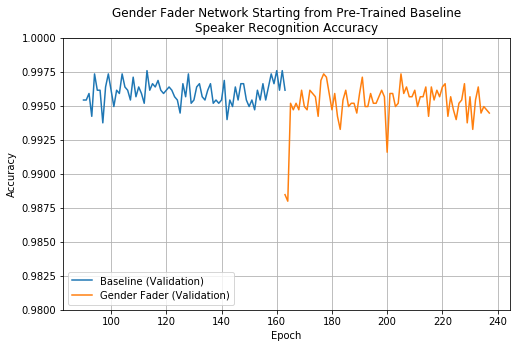

In [438]:
plt.figure(figsize=(8,5))
plt.plot(tm_base.data.epoch, tm_base.data.speaker_recognition_acc_eval)
plt.plot(sr_concat_baseline.data.epoch, sr_concat_baseline.data.speaker_recognition_acc_eval)
plt.grid(True)
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.98, 1])
plt.legend(('Baseline (Validation)', 'Gender Fader (Validation)'))
plt.title('Gender Fader Network Starting from Pre-Trained Baseline\nSpeaker Recognition Accuracy')
plt.savefig(os.path.join(save_folder, 'fader_concat_from_baseline_spkr_recog'))

In [674]:
sr_concat_baseline_FF = tm.TrainingMonitor('fader_concat_baseline163_spkr_recog_20180820_FF.csv', 
                                        exp_name='fader_gender_concat_baseline163_20180720', 
                                        path="/home/ubuntu/msc-project-fader-networks/training_logs")

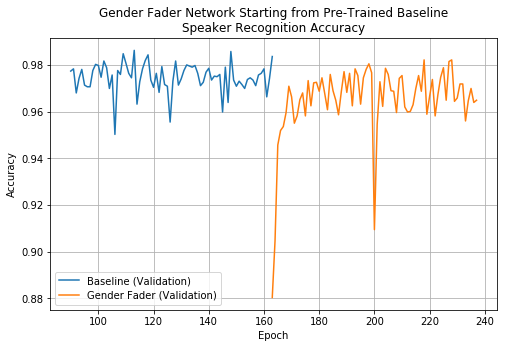

In [675]:
plt.figure(figsize=(8,5))
plt.plot(tm_base_FF.data.epoch, tm_base_FF.data.speaker_recognition_acc_eval)
plt.plot(sr_concat_baseline_FF.data.epoch, sr_concat_baseline_FF.data.speaker_recognition_acc_eval)
plt.grid(True)
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.ylim([0.98, 1])
plt.legend(('Baseline (Validation)', 'Gender Fader (Validation)'))
plt.title('Gender Fader Network Starting from Pre-Trained Baseline\nSpeaker Recognition Accuracy')
plt.savefig(os.path.join(save_folder, 'fader_concat_from_baseline_spkr_recog_FF'))

In [683]:
sr_concat_baseline_FF.data.iloc[sr_concat_baseline_FF.data.valid_loss.idxmin()].speaker_recognition_acc_eval

0.98150816522599993

**TODO**
* !!!!!!!!! CHANGE THIS TO EVAL MODE RATHER THAN TEACHER FORCING! AND PICK UP THE CORRECT FF BASELINE !!!!!
* Finish building speaker recognition curves for the concat method, and update the plot in the report

## t-sne etc.?

In [19]:
# load discriminator checkpoint

# load model and extract speaker embeddings

# run t-sne on the speaker embeddings

In [20]:
import training_monitor as tm
import model_discriminator as md

In [21]:
b_baseline = False
if b_baseline:
    checkpoint = '/home/ubuntu/msc-project-master/msc-project-master/checkpoints/vctk-all-2-v2/bestmodel.pth'
else:
    checkpoint = 'checkpoints/fader_gender_concat_baseline163_20180720/epoch_181.pth'

discriminator_checkpoint = 'checkpoints/fader_gender_concat_baseline163_20180720/discriminator_epoch_181.pth'

In [22]:
start_epoch = 1

checkpoint_args_path = os.path.dirname(checkpoint) + '/args.pth'
checkpoint_args = torch.load(checkpoint_args_path)

if b_baseline:
    checkpoint_args[0].speaker_hidden_size = 256
    checkpoint_args[0].gender_method = 'add'

In [23]:
start_epoch = checkpoint_args[3]
model = Loop(checkpoint_args[0])
model.cuda()

In [24]:
if b_baseline:
    tmp = torch.load(checkpoint, map_location=lambda storage, loc: storage)
    embeddings = tmp['encoder.lut_s.weight'].cpu().numpy()
else:
    model.load_state_dict(torch.load(checkpoint, map_location=lambda storage, loc: storage))
    embeddings = model.encoder.lut_s.weight.cpu().data.numpy()

In [25]:
speaker_info = md.get_speaker_info_for_discriminator()

In [230]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [231]:
pca.explained_variance_ratio_

array([ 0.02672514,  0.02250146], dtype=float32)

In [232]:
idx_m = speaker_info['gender'] == 'M'
idx_f = speaker_info['gender'] == 'F'

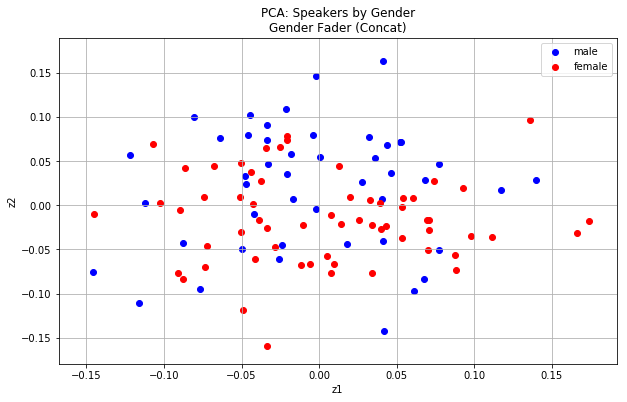

In [233]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.xlabel('z1')
plt.ylabel('z2')
if b_baseline:
    plt.title('PCA: Speakers by Gender\nBaseline (Concat)')
    plt.savefig(os.path.join(save_folder, 'baseline_embedding_pca'))
else:
    plt.title('PCA: Speakers by Gender\nGender Fader (Concat)')
    plt.savefig(os.path.join(save_folder, 'fader_concat_from_baseline_embedding_pca'))

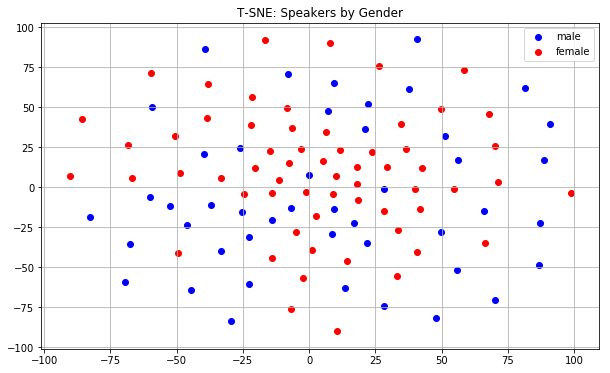

In [193]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('T-SNE: Speakers by Gender')
plt.show()

In [215]:
# checking that explained_variance_ratio_adds to 1, not to 100
np.random.seed(0)
my_matrix = np.random.randn(20, 5)

my_model = PCA(n_components=5)
my_model.fit_transform(my_matrix)

print my_model.explained_variance_
print my_model.explained_variance_ratio_
print my_model.explained_variance_ratio_.cumsum()


[ 1.58691121  1.36183634  1.02149516  0.64960702  0.33188507]
[ 0.32047581  0.27502207  0.20629036  0.13118776  0.067024  ]
[ 0.32047581  0.59549787  0.80178824  0.932976    1.        ]


## Run speaker recogntion through samples...

#### Load speaker recognition model

In [241]:
data

'/home/ubuntu/loop/data/vctk'

In [32]:
# Load pre-trained SpeakerRecognition model
speaker_recog = sr.SpeakerRecognition(data_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                                           checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/speaker_recognition_vctk_all/bestmodel.pth',
                                           seq_len=300,
                                           nspk=107,
                                           max_seq_len=1000,
                                           batch_size=64,
                                           gpu=0,
                                           exp_name='notebook_test')

speaker_recog.reload_checkpoint()

#### Create samples by fading the gender variable

In [85]:
# generate the sample
spkr_id = 33
sentence_id = 307
# (33, 196, 201, 209)
# (34, 217)
# (45, 295)
# (55, 307)
#spkr_id, sentence_id = (34, 217)
#spkr_id, sentence_id = (45, 295) # good: most important thing... M scot
#spkr_id, sentence_id = (88, 105)
#spkr_id, sentence_id = (99, 115)
spkr_id, sentence_id = (6, 104) # good: what kind of man does that..., F Irish
spkr_id, sentence_id = (26, 104) # okay: that would be unlawful, F Welsh
spkr_id, sentence_id = (29, 104) # journalists..., M Birmingham, attention fails
spkr_id, sentence_id = (77, 250) # I would urge the government to think again, F Am, only okay
spkr_id, sentence_id = (88, 150) # attention fails
spkr_id, sentence_id = (89, 150) # the scots are great, F Am, not great
spkr_id, sentence_id = (90, 150) # why is that, M Am, not great
spkr_id, sentence_id = (91, 150) # the pilot was making a visual approach, F Nz, not great although accent seems preserved
spkr_id, sentence_id = (92, 150) # it's good for the city, F SA, doesn't capture the accent so well (limited data)
spkr_id, sentence_id = (94, 155) # this is a recipe for (long) 'disaster', F Ir, pretty good
spkr_id, sentence_id = (95, 155) # we would welcome a great emphasis... F Am, accent okay but attention poor
spkr_id, sentence_id = (95, 160) # you shouldn't have a stoppage... F Am, attention poor
spkr_id, sentence_id = (95, 195) # felt good about it, F Am, reasonable
spkr_id, sentence_id = (95, 203) # their expressions only reflected those of the audience, F Am, poor attention in middle but [1,0], [0,1] okay
spkr_id, sentence_id = (96, 160) # it had been played at festivals, F Ca, quite a good one
spkr_id, sentence_id = (96, 279) # we are talking about one family, F Ca, pretty good

#spkr_id, sentence_id = (70, 137) # we are very concerned about controller fatigue, M Ca, okay
#spkr_id, sentence_id = (70, 140) # how much of a cop out is that, M Ca, not great
#spkr_id, sentence_id = (79, 419) # there was no pressure at all, F Ca, okay
#spkr_id, sentence_id = (66, 396) # the woman is basically off her head, M Ir, okay-ish
#spkr_id, sentence_id = (66, 329) # I feel sorry for the reds, M Ir, okay-ish

#spkr_id, sentence_id = (6, 108) # before the game we went for a pint, F Eng, quite good!

# samples for Simon King
# 272: scottish male
spkr_id, sentence_id = (45, 295) # good: most important thing... M scot
#spkr_id, sentence_id = (45, 13) # 
#spkr_id, sentence_id = (45, 44) # 
#spkr_id, sentence_id = (45, 68) # 
#spkr_id, sentence_id = (45, 80) #
#spkr_id, sentence_id = (45, 353) #
#spkr_id, sentence_id = (45, 374) #
#spkr_id, sentence_id = (45, 324) #

# 231: F Eng
spkr_id, sentence_id = (6, 108)
#spkr_id, sentence_id = (6, 120)
#spkr_id, sentence_id = (6, 152)
#spkr_id, sentence_id = (6, 183)
#spkr_id, sentence_id = (6, 233)

# 253: F Welsh
#spkr_id, sentence_id = (26, 104)
#spkr_id, sentence_id = (26, 191)
#spkr_id, sentence_id = (26, 212)

# 343: F Canadian
#spkr_id, sentence_id = (96, 160)
#spkr_id, sentence_id = (96, 333)
#spkr_id, sentence_id = (96, 350)

# 298: M Irish
#spkr_id, sentence_id = (66, 329)
#spkr_id, sentence_id = (66, 137)
#spkr_id, sentence_id = (66, 235)
#spkr_id, sentence_id = (66, 262)

# 294: F Am
#spkr_id, sentence_id = (63, 64)
#spkr_id, sentence_id = (63, 86)
#spkr_id, sentence_id = (63, 372)

#text = 'The threats would be a major escalation of the dispute and sparked further falls on stock markets.'
text = 'China responded by accusing the US of blackmail'
text = 'How trying to stay cool could make the world even hotter'
text = "The question on the lips of every England fan"
text = 'either a tomato or a schedule in progress'
npz = "p%d_%d.npz" % (speaker_info.loc[spkr_id].id, sentence_id)
npz = "p%d_%03d.npz" % (speaker_info.loc[spkr_id].id, sentence_id)
#'{num:03d}'.format(num=sample_id)
#speaker_info[speaker_info.id == 294]
#npz = ''

speaker_info[spkr_id:spkr_id+1]

,id,age,gender,accents,region
6,231,23,F,English,Southern England


In [86]:
npz_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features'
output_dir='./'
norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

output_dir = '/home/ubuntu/msc-project-master/msc-project-master/docs/fader'

txt, feat, pre_calc_feat = nu.npy_loader_phonemes(os.path.join(npz_path, npz))

txt = Variable(txt.unsqueeze(1), volatile=True)
feat = Variable(feat.unsqueeze(1), volatile=True)
spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)

txt = txt.cuda()
feat = feat.cuda()
spkr = spkr.cuda()
model.train() #! teacher forcing
model.noise=0 #! no noise
model.eval()
print ''

In [87]:
# linear mixing
#gender_sweep = [[2, 0], [1.5, 0], [1, 0], [0.8, 0.2], [0.6, 0.4], [0.5, 0.5], [0, 0],
#                [0.4, 0.6], [0.2, 0.8],  [0, 1], [0, 1.5], [0, 2]]

gender_sweep = [[1, 0], [0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.6, 0.4], [0.5, 0.5],
                [0.4, 0.6], [0.3, 0.7],  [0.2, 0.8], [0.1, 0.9], [0, 1]]
plt_title = 'test'
num_gender_sweep = len(gender_sweep)

In [88]:
#gender = np.array(0).reshape(-1)
#gender = np.array([-1, 0]).reshape(1,2)
all_feat = []

output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id) + '_orig_20180820'
generate_merlin_wav(feat.data.cpu().numpy(),
                    output_dir,
                    output_file,
                    norm_path)

for g in gender_sweep:
    output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id) + '_gender_concat_linear_' + str(g[0]) + "_" + str(g[1]) 
    gender = np.array(g).reshape(1,2)
    loop_feat, attn = model([txt, spkr, gender], feat)
    loop_feat, attn = nu.trim_pred(loop_feat, attn)    
    
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    all_feat.append(loop_feat.data.cpu().numpy())

complete p231_108_6_orig_20180820.wav.
complete p231_108_6_gender_concat_linear_1_0.wav.
complete p231_108_6_gender_concat_linear_0.9_0.1.wav.
complete p231_108_6_gender_concat_linear_0.8_0.2.wav.
complete p231_108_6_gender_concat_linear_0.7_0.3.wav.
complete p231_108_6_gender_concat_linear_0.6_0.4.wav.
complete p231_108_6_gender_concat_linear_0.5_0.5.wav.
complete p231_108_6_gender_concat_linear_0.4_0.6.wav.
complete p231_108_6_gender_concat_linear_0.3_0.7.wav.
complete p231_108_6_gender_concat_linear_0.2_0.8.wav.
complete p231_108_6_gender_concat_linear_0.1_0.9.wav.
complete p231_108_6_gender_concat_linear_0_1.wav.


In [89]:
all_prob_correct = np.zeros(num_gender_sweep)
all_above_one_pct = []

display(speaker_info[spkr_id:spkr_id+1])

for idx in range(num_gender_sweep):
    tmp = Variable(torch.from_numpy(all_feat[idx])).cuda()
    num_correct_pred, num_samples, correct_pred, op = speaker_recog.evaluate_synth(feat=tmp, spkr=spkr)
    #print correct_pred
    sm = F.softmax(op, dim=1).data.cpu().numpy()
    #plt.bar(range(107), sm.flatten())
    #print spkr
    p = pd.DataFrame({'Prob':100*sm.flatten()}).sort_values('Prob', ascending=0)
    s = speaker_info.iloc[pd.Series(np.array(p.index))]
    c = s.join(p)
    
    all_prob_correct[idx] = p.loc[spkr.data.cpu().numpy()].Prob
    
    #display(c[c.Prob > 1])
    all_above_one_pct.append(c[c.Prob >= 1])


,id,age,gender,accents,region
6,231,23,F,English,Southern England


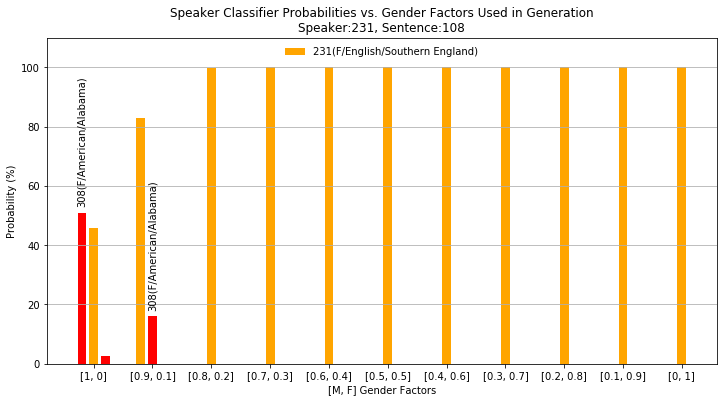

In [90]:
plt.figure(figsize=(12,6))
ind = np.arange(num_gender_sweep)
width = 0.15
bar_offset = 0.2
#p1 = plt.bar(ind, all_prob_correct, width=width, color='orange')

cum_prob = all_prob_correct.copy()

for idx in range(num_gender_sweep):
    offset_m = 0.0
    offset_f = 0.0
    num_bars = len(all_above_one_pct[idx])
    this_offset = -(num_bars / 2) * bar_offset
    for i in range(num_bars):
        #if all_above_one_pct[idx].iloc[i].name != spkr.data.cpu().numpy():
        this_spkr = all_above_one_pct[idx].iloc[i]
        if this_spkr.name == spkr.data.cpu().numpy():
            c = 'orange'
        else:
            if this_spkr.gender == 'M':
                c = 'b'
                offset_m += -bar_offset
            #    this_offset = offset_m
            else:
                c = 'r'
                offset_f += bar_offset
            #    this_offset = offset_f

        #plt.scatter(idx, this_spkr.Prob, c=c)
        if c == 'orange':
            b = plt.bar(idx+this_offset, this_spkr.Prob, color=c, width=width)
        else:
            plt.bar(idx+this_offset, this_spkr.Prob, color=c, width=width)

        if (this_spkr.name != spkr.data.cpu().numpy()) and this_spkr.Prob >= 5:
            fd = dict()
            fd['color'] = 'k'
            fd['size'] = 10
            lab = str(this_spkr.id) + '(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'

            lab_pos = this_spkr.Prob + 2
            plt.text(idx+this_offset, lab_pos, lab, fontdict=fd, rotation=90, ha='center', va='bottom')

            cum_prob[idx] += this_spkr.Prob

        this_offset += bar_offset
            
plt.xticks(range(num_gender_sweep), gender_sweep)
plt.grid(axis='y')
plt.ylim([0, 110])
plt.yticks(np.arange(0, 110, 20))
plt.xlabel('[M, F] Gender Factors')
plt.ylabel('Probability (%)')
this_spkr = speaker_info.iloc[spkr.data.cpu().numpy()]
lab_txt = str(this_spkr.id.values[0]) + '(' + this_spkr.gender.values[0] \
+ '/' + this_spkr.accents.values[0] + '/' + this_spkr.region.values[0] + ')'
plt.title('Speaker Classifier Probabilities vs. Gender Factors Used in Generation\nSpeaker:' 
          + npz.split('_')[0][1:] +', Sentence:' + npz.split('_')[1][:-4])

plt.legend(b, (lab_txt,), loc='upper center', frameon=False)
#plt.savefig(os.path.join(save_folder, 'spkr_classifier_gender_sweep_' + npz[:-4]))
#plt.savefig(os.path.join(save_folder, 'spkr_classifier_gender_sweep_extreme_' + npz[:-4]))

### Check the sample created for the most likely person...
* Has the model just shifted to another known speaker?

In [1045]:
g = [0, 1]

sm_spkr = speaker_info[speaker_info.id == 299].index[0]
sm_spkr_var = Variable(torch.LongTensor([sm_spkr]), volatile=True).cuda()

In [1046]:
output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id) \
    +'_gender_concat_softmax_speaker_' + str(g[0]) + '_' + str(g[1]) + '_' + str(sm_spkr)
gender = np.array(g).reshape(1,2)
loop_feat, attn = model([txt, sm_spkr_var, gender], feat)
loop_feat, attn = nu.trim_pred(loop_feat, attn)    

generate_merlin_wav(loop_feat.data.cpu().numpy(),
                    output_dir,
                    output_file,
                    norm_path)

complete p298_262_66_gender_concat_softmax_speaker_0_1_67.wav.


In [1047]:
IPython.display.display(Audio(output_file + '.wav', autoplay=False))

### Old Plots

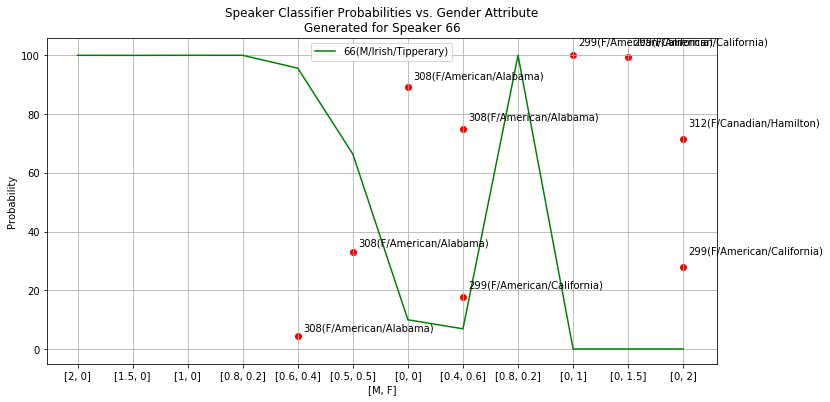

In [893]:
plt.figure(figsize=(12,6))
plt.plot(all_prob_correct, 'g')
lab = str(this_spkr.id) + '(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'
#plt.text(idx+0.2, all_above_one_pct[idx].iloc[i].Prob + 1, lab, fontdict=fd)
    
for idx in range(num_gender_sweep):
    for i in range(len(all_above_one_pct[idx])):
        if all_above_one_pct[idx].iloc[i].name != spkr.data.cpu().numpy():
            this_spkr = all_above_one_pct[idx].iloc[i]
            if this_spkr.gender == 'M':
                c = 'b'
            else:
                c = 'r'
                
            plt.scatter(idx, this_spkr.Prob, c=c)
            fd = dict()
            fd['color'] = 'k'
            fd['size'] = 10
            lab = str(this_spkr.id) + '(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'
            plt.text(idx+0.1, all_above_one_pct[idx].iloc[i].Prob + 0.05 + 0.4*idx, lab, fontdict=fd)
plt.xticks(range(num_gender_sweep), gender_sweep)
plt.grid(True)
plt.xlabel('[M, F]')
plt.ylabel('Probability')
plt.title('Speaker Classifier Probabilities vs. Gender Attribute\nGenerated for Speaker ' + str(spkr.data.cpu().numpy()[0]))
this_spkr = speaker_info.iloc[spkr.data.cpu().numpy()]
lab_txt = str(this_spkr.index[0]) + '(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'
plt.legend(lab_txt, loc='upper center')

plt.savefig(os.path.join(save_folder, 'spkr_classifier_gender_sweep_' + str(spkr.data.cpu().numpy()[0])))

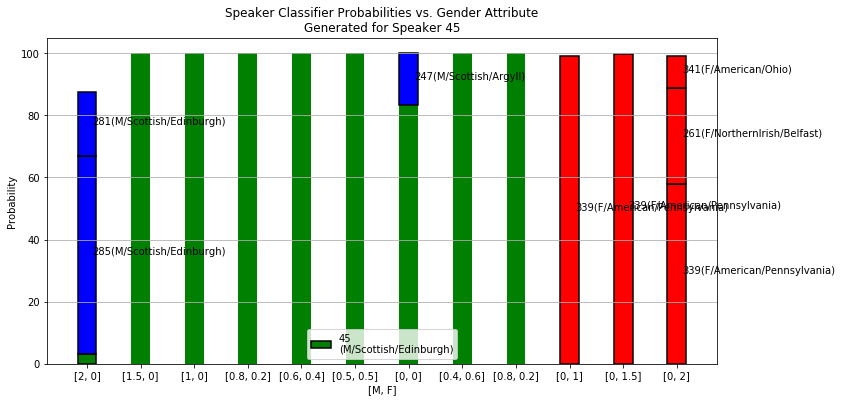

In [750]:
plt.figure(figsize=(12,6))
ind = np.arange(num_gender_sweep)
width = 0.35 
p1 = plt.bar(ind, all_prob_correct, width=width, color='g', linewidth=np.ones(num_gender_sweep)*1.5, edgecolor='k')

cum_prob = all_prob_correct.copy()

for idx in range(num_gender_sweep):
    for i in range(len(all_above_one_pct[idx])):
        if all_above_one_pct[idx].iloc[i].name != spkr.data.cpu().numpy():
            this_spkr = all_above_one_pct[idx].iloc[i]
            if this_spkr.gender == 'M':
                c = 'b'
            else:
                c = 'r'
                
            #plt.scatter(idx, this_spkr.Prob, c=c)
            plt.bar(idx, this_spkr.Prob, color=c, width=width, bottom=cum_prob[idx], linewidth=1.5, edgecolor='k')
            
            fd = dict()
            fd['color'] = 'k'
            fd['size'] = 10
            lab = str(this_spkr.id) + '(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'
            
            lab_pos = cum_prob[idx] + this_spkr.Prob/2
            plt.text(idx+0.1, lab_pos, lab, fontdict=fd)
            
            cum_prob[idx] += this_spkr.Prob
            
plt.xticks(range(num_gender_sweep), gender_sweep)
plt.grid(axis='y')
plt.xlabel('[M, F]')
plt.ylabel('Probability')
plt.title('Speaker Classifier Probabilities vs. Gender Attribute\nGenerated for Speaker ' + str(spkr.data.cpu().numpy()[0]))
this_spkr = speaker_info.iloc[spkr.data.cpu().numpy()]
lab_txt = str(this_spkr.index[0]) + '\n(' + this_spkr.gender + '/' + this_spkr.accents + '/' + this_spkr.region + ')'
plt.legend(lab_txt, loc='lower center')
#plt.savefig(os.path.join(save_folder, 'spkr_classifier_gender_sweep_' + str(spkr.data.cpu().numpy()[0])))

**TODO**
* do it for unseen text? Or validation text?
* sweep values and plot probabilities
* do a nice plot

## Gender Classification Model

In [7]:
import gender_recognition as gr

In [8]:
gender_recog = gr.GenderRecognition(data_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                        checkpoint=None,
                        seq_len=300,
                        nspk=107,
                        max_seq_len=1000,
                        batch_size=64,
                        gpu=0,
                        exp_name='gender_recognition_vctk_all_107_20180821')

/usr/local/lib/python2.7/dist-packages/torch/backends/cudnn/__init__.py:48: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


In [9]:
eval_dict = gender_recog.train(num_epochs=2)

Eval epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy (epoch 1): 0.994


Train epoch 2:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy (epoch 1): 0.994


Eval epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Training accuracy (epoch 2): 0.996


Eval epoch 1:   0%|          | 0/615 [00:00<?, ?it/s]

Validation accuracy (epoch 2): 0.994


Evaluation Valid (loss 0.00) epoch 1: 100%|██████████| 68/68 [00:04<00:00, 16.19it/s]


In [15]:
print sum(eval_dict['valid_correct'])
print len(eval_dict['valid_correct'])
# only wrong on 25 utterances

4139
4164


In [98]:
all_prob_correct_gender = np.zeros(num_gender_sweep)
all_prob_male = np.zeros(num_gender_sweep)
all_above_one_pct = []

display(speaker_info[spkr_id:spkr_id+1])

for idx in range(num_gender_sweep):
    tmp = Variable(torch.from_numpy(all_feat[idx])).cuda()
    num_correct_pred, num_samples, correct_pred, op = gender_recog.evaluate_synth(feat=tmp, spkr=spkr)
    #print correct_pred
    sm = F.softmax(op, dim=1).data.cpu().numpy()
    #plt.bar(range(107), sm.flatten())
    #print spkr
    p = pd.DataFrame({'Prob':100*sm.flatten()}).sort_values('Prob', ascending=0)
    s = speaker_info.iloc[pd.Series(np.array(p.index))]
    c = s.join(p)
    
    this_gender = (gender_recog.speaker_info.loc[spkr.data.cpu().numpy()[0]].gender == 'M') * 1.0
    
    all_prob_correct_gender[idx] = p.loc[this_gender].Prob
    all_prob_male[idx] = p.loc[0].Prob
    
    #display(c[c.Prob > 1])
    #all_above_one_pct.append(c[c.Prob >= 1])


,id,age,gender,accents,region
6,231,23,F,English,Southern England


Text(0.5,1,u'Speaker Classifier Probabilities vs. Gender Attribute\nGenerated for Speaker 6')

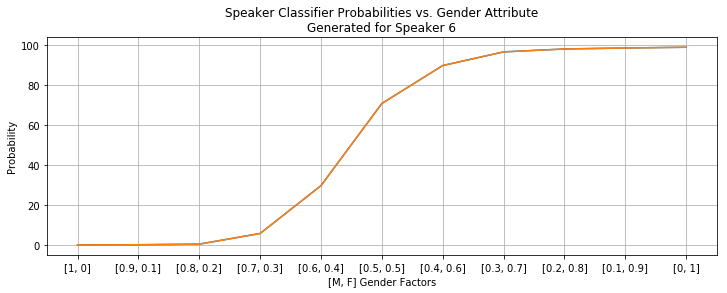

In [99]:
plt.figure(figsize=(12,4))
plt.plot(range(num_gender_sweep), all_prob_correct_gender)
plt.plot(range(num_gender_sweep), all_prob_male)
plt.grid(True)
plt.xticks(range(num_gender_sweep), gender_sweep)
plt.grid(True)
plt.xlabel('[M, F] Gender Factors')
plt.ylabel('Probability')
plt.title('Speaker Classifier Probabilities vs. Gender Attribute\nGenerated for Speaker ' + str(spkr.data.cpu().numpy()[0]))

1.0